These are the packages required to run the program.

In [3]:
import matplotlib.pyplot as plot 
import pandas as pd 
import datetime as dtime 
import numpy as np 
import os,sys,math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Reading the CSV file by specifying the path to it

In [4]:
df = pd.read_csv("/home/ritesh/Work/Big Data Assignment 2/F.csv")

We remove entries which have missing values and check first 10 values

In [5]:
df=df.dropna(axis=0, how='any')
df[:10]

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,0.000000,2.173495,2.149165,2.153220,0.277407,1091238
1,1972-06-02,2.153220,2.173495,2.141055,2.149165,0.276884,1174468
2,1972-06-05,2.149165,2.169440,2.141055,2.149165,0.276884,5209582
3,1972-06-06,2.149165,2.157275,2.116725,2.124835,0.273750,1424158
4,1972-06-07,2.124835,2.137000,2.112670,2.112670,0.272182,675088
5,1972-06-08,2.112670,2.128890,2.096449,2.096449,0.270093,1038834
6,1972-06-09,2.096449,2.100504,2.043734,2.084284,0.268525,6590583
7,1972-06-12,2.084284,2.108615,2.068064,2.084284,0.268525,1430323
8,1972-06-13,2.084284,2.104560,2.084284,2.100504,0.270615,934026
9,1972-06-14,2.108615,2.153220,2.108615,2.132945,0.274794,2940794


Next we set the first column 'date' as the index, which is a unique identifier for each record. It is also converted to appropriate date format.

In [6]:
df.index = pd.to_datetime(df.index,format='%Y-%m-%d')

Now we plot Opening and closing prices over the years

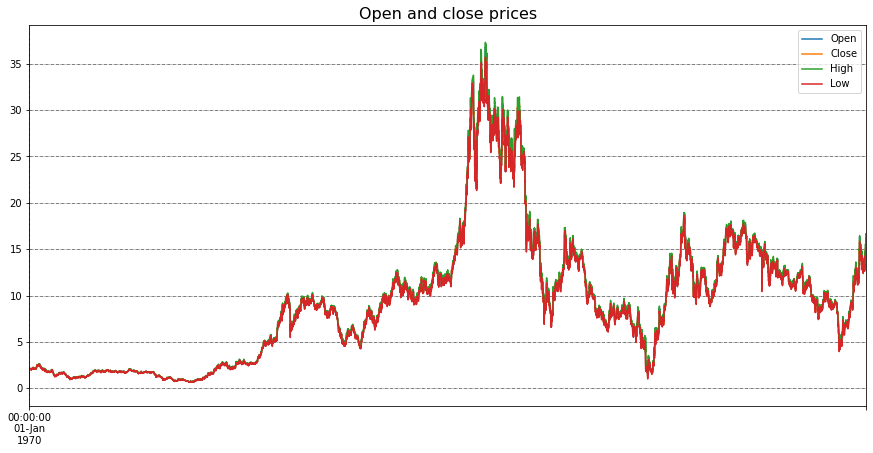

In [7]:
df['Open'].plot(label='Open',figsize=(15,7),legend='True')
df['Close'].plot(label='Close',figsize=(15,7),legend='True')
df['High'].plot(label='High',figsize=(15,7),legend='True')
df['Low'].plot(label='Low',figsize=(15,7),legend='True')
plot.title("Open and close prices", fontsize=16)
plot.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

We now subset the dataframe rows and determine number of entries in training dataset, which is 80% of the whole dataset

In [8]:
data = df.filter(['Close'])
dataset = data.values
training_data_length = math.ceil(len(dataset)* .8)
print(training_data_length)

9967


Scaling the data using MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.04192544],
       [0.04181281],
       [0.04181281],
       ...,
       [0.42762634],
       [0.44179137],
       [0.43429226]])

Splitting data into training and testing datasets

In [10]:
training_data = scaled_data[0:training_data_length, : ]
x_training = []
y_training = []

for x in range(60, len(training_data)):
    x_training.append(training_data[x-60:x, 0])
    y_training.append(training_data[x,0])

Converting training datasets into arrays

In [11]:
x_training , y_training = np.array(x_training), np.array(y_training)
x_training = np.reshape(x_training, (x_training.shape[0], x_training.shape[1], 1))
x_training.shape

(9907, 60, 1)

Now we build the LSTM model.
Optimiser parameter is used to improve on loss function & the loss function is to check how the model performed on training data.

In [12]:
lstm = Sequential()
lstm.add(LSTM(units = 50, return_sequences = True, input_shape = (x_training.shape[1],1)))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units = 50, return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units = 50))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1))
lstm.summary()
lstm.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['accuracy'])

2021-12-01 12:31:30.983147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-01 12:31:30.983196: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 12:31:30.983241: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2021-12-01 12:31:30.983534: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

We make the testing dataset and then fit the model. LSTM uses Tensorflow Compute Units (TPU's) as a hardware accelerator. Either a standalone USB accelerator or Google's Cloud TPU can make the first line in the code below run faster.
Code runs without a TPU too but takes about 5 minutes for a PC with 2 cores and 8 GB of RAM.
Epochs is the number of iterations when the entire frame is passed forward and backward through the neural network

In [13]:
lstm.fit(x_training,y_training, batch_size=1,epochs=1)
test_data = scaled_data[training_data_length-60:, :]
x_testing = []
y_testing = dataset[training_data_length: , :]

for i in range(60, len(test_data)):
    x_testing.append(test_data[i-60:i,0])

x_testing = np.array(x_testing)
x_testing = np.reshape(x_testing, (x_testing.shape[0],x_testing.shape[1], 1))


9907/9907 [==============================] - 377s 38ms/step - loss: 0.0021 - accuracy: 2.0188e-04


Checking dimensionality of x_testing for compatibility purposes

In [14]:
x_testing.shape
x_training.shape

(9907, 60, 1)

We start the prediction using the model. 
Root mean Square error is also printed. 

In [15]:
prediction = lstm.predict(x_testing)
y_prediction = scaler.inverse_transform(prediction)
rmse = np.sqrt(np.mean(y_prediction - y_testing)**2)
print(rmse)

0.8622219794662273


/tmp/ipykernel_11571/4252294227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = y_prediction


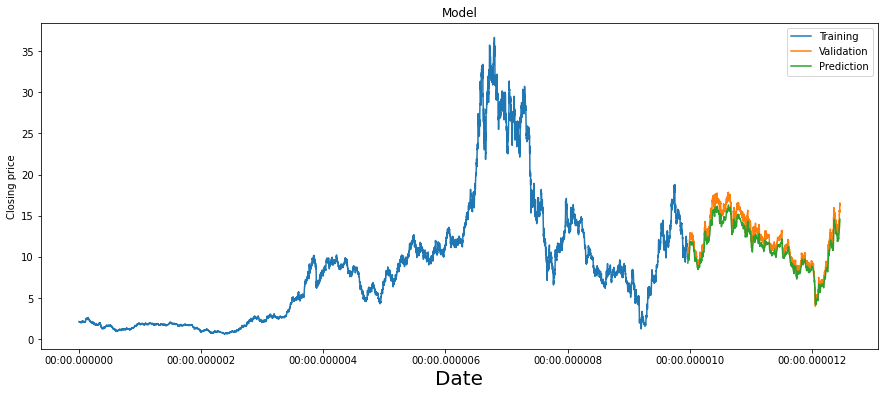

In [16]:
train = data[0: training_data_length]
valid = data[training_data_length :]
valid['predictions'] = y_prediction
plot.figure(figsize=(15,6))
plot.title('Model')
plot.xlabel('Date',fontsize=20)
plot.ylabel('Closing price')
plot.plot(train['Close'])
plot.plot(valid[['Close','predictions']])
plot.legend(['Training','Validation','Prediction'])
plot.show()